# <center>Project 4 on Fuzzy system</center>

Subject: Fuzzy Rule Base

Name: Hesam Mousavi

Student number: 9931155

Master student

<p align="center">
 <img src="report/fuzzy-system.png", width="500">
</p>

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
tex2jax: {
inlineMath: [['$','$'], ['\\(','\\)']],
processEscapes: true},
jax: ["input/TeX","input/MathML","input/AsciiMath","output/CommonHTML"],
extensions: ["tex2jax.js","mml2jax.js","asciimath2jax.js","MathMenu.js","MathZoom.js","AssistiveMML.js", "[Contrib]/a11y/accessibility-menu.js"],
TeX: {
extensions: ["AMSmath.js","AMSsymbols.js","noErrors.js","noUndefined.js"],
equationNumbers: {
autoNumber: "AMS"
}
}
});
</script>

In [1]:
import numpy as np
from fcmeans import FCM
from sklearn.metrics import f1_score, precision_score
from copy import deepcopy
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from my_io import read_dataset_to_X_and_y
np.random.seed(4)


## Build Class to easily have all the variables

I like to have my variable all together so I build a class and named it
UniSet(short form of universal set)

Read dataset with my function on my_io module that can shuffle sample and
correct missing values also normalized the feature.  

In here I shuffle data and use class-mean for the missing values then
normalized it with the scaling method into range [0.1, 1] (all values $\in [0.1, 1]$)

I use all the features(12) and change sex from m, f to 0, 1 (actually I map
each string to a specific number in my_io module)


In [2]:
class UniSet():
    def __init__(self, file, range_feature, range_label,
                 normalization='scaling', min_value=0.1, max_value=1,
                 shuffle=False, about_nan='class_mean'):
        np.random.seed(1)
        sample, label = read_dataset_to_X_and_y(
            file, range_feature, range_label, normalization, min_value,
            max_value, shuffle=shuffle, about_nan=about_nan)
        self.min_value = min_value
        self.max_value = max_value
        self.universal = sample.astype(float)
        self.label = label
        self.number_of_feature = sample.shape[1]
        self.size_of_universal = sample.shape[0]
        self.diffrent_label = np.unique(label)
        self.number_of_diffrent_label = self.diffrent_label.shape[0]


uni_total = UniSet(
    'dataset/hcvdat0.csv', (2, 14), (1, 2),
    normalization='scaling', shuffle=True, about_nan='class_mean')


print(f'The whole dataset is {uni_total.universal.shape} matrix')


The whole dataset is (615, 12) matrix


> #### Details 
>
> In my_io module I have a function named read_dataset_to_X_and_y
>  that get dataset file, range of attributes that are our features,
>  range of attributes that are our labels, normalization which is
>  our normalization method, shuffle which if be True our samples be
>  shuffled, and about_nan that can be "delete" which delete samples
>  with NA values or "class_mean" which replace NA values with mean of
>  that feature in the sample class
>
> Also as I mentioned above this function can get string attributes too
>  by mapping each string to a specific value so now our labels $\in [0, 4]$
>
> I change NA value with class-mean because It doesn't change the
>  similarity(or distance) of two samples in one class 
>
> In my class, I have all things that I'll need such as universal
>  (sample data), their label, number of features, size of universal
>  (dataset), different labels (unique labels), and number of different labels.
>
> Our labels in this dataset is attributed [1, 2) and features are attributed
>  [2, 14) (12 features)


## Split the whole dataset to Train and Test

As I shuffle the dataset before, now I just consider the first 80%
of the data for the train and the rest for the test case



In [3]:
def split_train_test(universe: UniSet, train_size: float) -> list[UniSet]:
    train = deepcopy(universe)
    test = deepcopy(universe)
    train.size_of_universal = \
        int(universe.size_of_universal*train_size)
    train.universal = \
        universe.universal[0:train.size_of_universal]
    train.label = \
        universe.label[0:train.size_of_universal]
    test.size_of_universal = (
        universe.size_of_universal - train.size_of_universal)
    test.universal = \
        universe.universal[train.size_of_universal:]
    test.label = \
        universe.label[train.size_of_universal:]

    return train, test


uni_train, uni_test = split_train_test(uni_total, 0.8)
print(f'The train dataset is {uni_train.universal.shape} matrix')
print(f'The test dataset is {uni_test.universal.shape} matrix')


The train dataset is (492, 12) matrix
The test dataset is (123, 12) matrix


> #### Details 
>
> I create two classes for train and test by copying the total set and
just changing universal, level, and size of universal for both train and test

## Create a class for our rule-based system

It contains all variables for our system

In [4]:
class RuleBase():
    def __init__(self, number_of_feature: int, min_feature, max_feature):
        self.number_of_feature = number_of_feature
        self.feature_range = np.arange(min_feature, max_feature + 0.01, 0.01)
        self.min_feature = min_feature
        self.max_feature = max_feature
        self.mid_feature = (max_feature + min_feature) / 2
        self.width = None
        self.membership = {'low': None, 'med': None, 'high': None}
        self.rules = []
        self.number_of_rule = None


rule_base = RuleBase(
    uni_train.number_of_feature,
    uni_total.min_value, uni_train.max_value)

> #### Details 
>
> Such as the minimum and maximum values of features (remember that all features are normalized between [min, max]), the width of words, membership functions for each word, rules, and the number of rules

## Design membership function for low, medium, and high on feature range for linguistic variables

I decided to create three sets on all features('low', 'med', 'high')

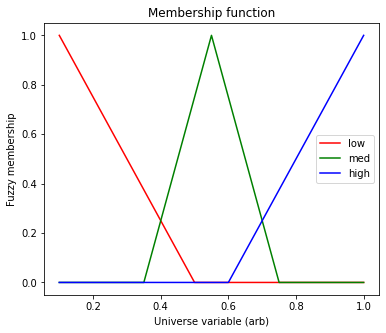

In [5]:
def create_linguistic_variables(
        rule_base: RuleBase, width: int = 0.4,
        plot: bool = False, save: bool = False):
    rule_base.width = width

    rule_base.membership['low'] = fuzz.trimf(
        rule_base.feature_range,
        [rule_base.min_feature, rule_base.min_feature,
            rule_base.min_feature + width])

    rule_base.membership['med'] = fuzz.trimf(
        rule_base.feature_range,
        [rule_base.mid_feature - width/2, rule_base.mid_feature,
            rule_base.mid_feature + width/2])

    rule_base.membership['high'] = fuzz.trimf(
        rule_base.feature_range,
        [rule_base.max_feature - width, rule_base.max_feature,
            rule_base.max_feature])

    if(plot is True or save is True):
        plt.figure(figsize=(6, 5))
        plt.plot(
            rule_base.feature_range, rule_base.membership['low'],
            'r', label='low')

        plt.plot(
            rule_base.feature_range, rule_base.membership['med'],
            'g', label='med')

        plt.plot(
            rule_base.feature_range, rule_base.membership['high'],
            'b', label='high')
        plt.ylabel('Fuzzy membership')
        plt.xlabel('Universe variable (arb)')
        plt.title('Membership function')
        plt.legend()
        if(save):
            plt.savefig('report/Membership-function.png')
        if(plot):
            plt.show()


create_linguistic_variables(rule_base, 0.4, True)


> #### Details 
>
> I have normalized all of my features between 0.1 and 1.0

## Fuzzify a value

It gets a value and returns a linguistic variable based on our fuzzy-set

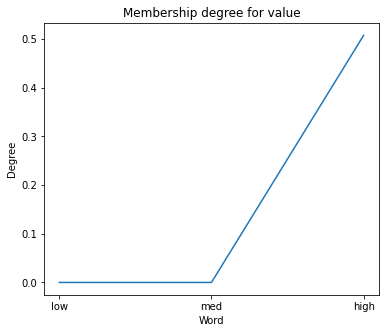

Word for 0.8031633421141696 is high with degree 0.5079083552854241


In [6]:
def fuzzify_value(value: float, rule_base: RuleBase, plot: bool = False):
    degrees = []
    for word in rule_base.membership:
        degrees.append((fuzz.interp_membership(
            rule_base.feature_range, rule_base.membership[word], value), word))
    max_degree = np.argmax(list(list(zip(*degrees))[0]))
    if(plot is True):
        plt.figure(figsize=(6, 5))
        plt.plot(['low', 'med', 'high'], list(list(zip(*degrees))[0]))
        plt.ylabel('Degree')
        plt.xlabel('Word')
        plt.title('Membership degree for value')
        plt.show()
    return degrees[max_degree]

random_value = np.random.rand()
degree, word = fuzzify_value(random_value, rule_base, True)
print(f'Word for {random_value} is {word} with degree {degree}')


> #### Details 
>
> This will find the maximum degree of membership for all of our fuzzy-sets for linguistic variables and return the word with the highest degree.

## Fuzzification

It gets a sample with float-values for each feature and fuzzified it and return a sample with linguistic-values

In [7]:
def fuzzification(sample: np.ndarray, rule_base: RuleBase):
    fuzzy_sample = []
    for i in range(rule_base.number_of_feature):
        fuzzy_sample.append(fuzzify_value(sample[i], rule_base)[1])
    return np.array(fuzzy_sample)

random_sample = uni_train.universal[
    np.random.randint(uni_train.size_of_universal)]
fuzzy_random_sample = fuzzification(random_sample, rule_base)
print(
    f'Random sample\t{np.round(random_sample, 2)}\n',
    f'Fuzzified sample {fuzzy_random_sample}')


Random sample	[0.83 0.1  0.44 0.25 0.17 0.15 0.13 0.67 0.54 0.16 0.14 0.64]
 Fuzzified sample ['high' 'low' 'med' 'low' 'low' 'low' 'low' 'med' 'med' 'low' 'low' 'med']


> #### Details 
>
> we'll find a fuzzified value for each feture of our sample

## Find rule

Initially, the idea was to choose each sample as a rule,
but as the number of rules grows, I use the fuzzy-c-mean
algorithm to cluster similar samples in the class and pick
centroids and fuzzify them to get rules in each class.

In [8]:
def find_rule(uni: UniSet, rule_base: RuleBase, cluster_size: int):
    for label in uni.diffrent_label:
        class_label = uni.universal[(uni.label == label).flatten()]
        size_class_i = class_label.shape[0]
        number_of_cluster = np.ceil(size_class_i / cluster_size)
        f_cmean = FCM(n_clusters=number_of_cluster)
        f_cmean.fit(class_label)
        centers = f_cmean.centers
        for rule in centers:
            rule_fuzzy = fuzzification(rule, rule_base)
            rule_fuzzy = np.hstack([rule_fuzzy, label])
            rule_base.rules.append(rule_fuzzy)
    rule_base.rules = np.array(rule_base.rules)
    rule_base.number_of_rule = rule_base.rules.shape[0]


find_rule(uni_train, rule_base, 20)
print(f'The fuzzy rules is {rule_base.rules.shape} matrix')


The fuzzy rules is (27, 13) matrix


> #### Details 
>
> In each rule, there are 13 values, the first 12 of which
> are features, and the last one is the label

## Find class

<p align="center">
 <img src="report/find-class.jpeg", width="750">
</p>

**Fuzzification**: In order to find the firing level for each rule, fuzzify the sample (find membership degree for each feature) and then find the minimum(t-norm) of those for finding the firing level of a rule

**Inference**: Then get maximum(t-norm) from all the firing rule

**Defuzzification**: At the end in order to find the label, find arg-max

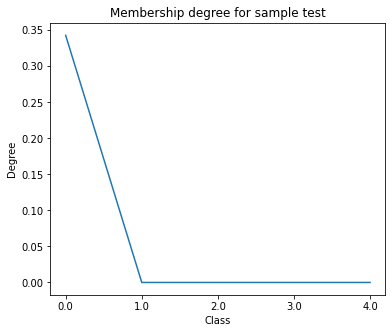

class of random sample [0.32 0.1  0.49 0.19 0.19 0.13 0.14 0.46 0.55 0.18 0.14 0.68] is 0.0


In [9]:
def find_class(
        sample: np.ndarray, rule_base: RuleBase, plot: bool = False):
    firing_level_class = np.zeros(np.unique(rule_base.rules[:, -1]).shape[0])
    for rule in rule_base.rules:
        #  Fuzzification
        membership_feature = []
        for i in range(rule_base.number_of_feature):
            value_sample = sample[i]
            word_rule_i = rule[i]
            membership_feature.append(
                fuzz.interp_membership(
                    rule_base.feature_range, rule_base.membership[word_rule_i],
                    value_sample))
        firing_level = np.min(membership_feature)

        #  Inference
        firing_level_class[int(float(rule[-1]))] = max(
            firing_level_class[int(float(rule[-1]))], firing_level
        )
    if(plot is True):
        plt.figure(figsize=(6, 5))
        plt.plot(np.unique(rule_base.rules[:, -1]), firing_level_class)
        plt.ylabel('Degree')
        plt.xlabel('Class')
        plt.title('Membership degree for sample test')
        plt.show()
    
    #  Defuzzification
    most_degrees = np.argwhere(
        firing_level_class == np.amax(firing_level_class)).reshape(-1)
    return float(np.random.choice(most_degrees))


random_sample = uni_test.universal[
    np.random.randint(uni_test.size_of_universal)]
class_sample = find_class(random_sample, rule_base, True)
print(f'class of random sample {np.round(random_sample, 2)} is {class_sample}')

> #### Details 
>
> In cases where the maximum degree isn't unique, I randomly choose one as a label

## Predict

For testing our model, in the begining I split data to train and test and biuld the model from train data, now it's time to test our model with test data

In [10]:
def predict(samples: np.ndarray, rule_base: RuleBase):
    number_of_sample = samples.shape[0]
    prediced_label = []
    for i in range(number_of_sample):
        sample = uni_test.universal[i]
        prediced_label.append(find_class(sample, rule_base))
    return np.array(prediced_label).reshape((-1, 1))


predict_label = predict(uni_test.universal, rule_base)


In [11]:
f1_score = f1_score(uni_test.label, predict_label, average='micro')

print(
    'f1-score of predicted labels on test data is',
    np.round(f1_score, 2))

precision_score = precision_score(
    uni_test.label, predict_label, average='micro')

print(
    'precision-score of predicted labels on test data is',
    np.round(precision_score, 2))


f1-score of predicted labels on test data is 0.41
precision-score of predicted labels on test data is 0.41


## <center>Thank you very much for taking the time to read this</center>